In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
import pandas as pd
#读取寻训练数据，为了使不同的端可以正常使用数据，故设置两段读取
#从kaggle训练集库读取
try:
    path = "E:\kaggledatabase\GiveMeSomeCredit\\"
    data = pd.read_csv(path+"cs-training.csv",index_col=0)#设置某列作为索引
except FileNotFoundError:#除非找不到文件，再从该目录下查找文件
    data = pd.read_csv("cs-training.csv",index_col=0)#设置某列作为索引

In [14]:
data.drop_duplicates(inplace=True)
data.index = range(data.shape[0])
data["NumberOfDependents"].fillna(int(data["NumberOfDependents"].mean()),inplace=True)
def fill_missing_rf(X,y,to_fill):

    """
    使用随机森林填补一个特征的缺失值的函数

    参数：
    X：要填补的特征矩阵
    y：完整的，没有缺失值的标签
    to_fill：字符串，要填补的那一列的名称
    """

    #构建新特征矩阵和新标签
    df = X.copy()
    fill = df.loc[:,to_fill]
    df = pd.concat([df.loc[:,df.columns != to_fill],pd.DataFrame(y)],axis=1)

    # 找出我们的训练集和测试集
    Ytrain = fill[fill.notnull()]
    Ytest = fill[fill.isnull()]
    Xtrain = df.iloc[Ytrain.index,:]
    Xtest = df.iloc[Ytest.index,:]

    #用随机森林回归来填补缺失值
    from sklearn.ensemble import RandomForestRegressor as rfr
    rfr = rfr(n_estimators=100)
    rfr = rfr.fit(Xtrain, Ytrain)
    Ypredict = rfr.predict(Xtest)

    return Ypredict

X = data.iloc[:,1:]
y = data["SeriousDlqin2yrs"]

#将参数输入函数
y_pred = fill_missing_rf(X,y,"MonthlyIncome")

#注意可以通过以下代码检验数据是否数量相同
y_pred.shape ==  data.loc[data.loc[:,"MonthlyIncome"].isnull(),"MonthlyIncome"].shape

#确认我们的结果合理之后，我们就可以将数据覆盖了
data.loc[data.loc[:,"MonthlyIncome"].isnull(),"MonthlyIncome"] = y_pred
data = data[data["age"] != 0]
data = data[data.loc[:,"NumberOfTimes90DaysLate"] < 90]
data.index = range(data.shape[0])


In [16]:
#探索标签的分布
X = data.iloc[:,1:]
y = data.iloc[:,0]

y.value_counts()#查看每一类别值得数据量，查看样本是否均衡
n_sample = X.shape[0]
n_1_sample = y.value_counts()[1]
n_0_sample = y.value_counts()[0]
print('样本个数：{}; 1占{:.2%}; 0占{:.2%}'.format(n_sample,n_1_sample/n_sample,n_0_sample/n_sample))
#imblearn是专门用来处理不平衡数据集的库，采用SMOTE的方法上采样解决样本分布不平衡的问题

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42) #实例化
X,y = sm.fit_sample(X,y)    #训练模型

n_sample_ = X.shape[0]#278584
n_1_sample_ = pd.Series(y).value_counts()[1]
n_0_sample_ = pd.Series(y).value_counts()[0]

print('样本个数：{}; 1占{:.2%}; 0占{:.2%}'.format(n_sample_,n_1_sample_/n_sample_,n_0_sample_/n_sample_))

样本个数：149165; 1占6.62%; 0占93.38%
样本个数：278584; 1占50.00%; 0占50.00%


In [17]:
    #训练模型


from sklearn.model_selection import train_test_split
X = pd.DataFrame(X)
y = pd.DataFrame(y)

X_train, X_vali, Y_train, Y_vali = train_test_split(X,y,test_size=0.3,random_state=420)

#训练集
model_data = pd.concat([Y_train, X_train], axis=1)
model_data.index = range(model_data.shape[0])
model_data.columns = data.columns
#验证集
vali_data = pd.concat([Y_vali, X_vali], axis=1)
vali_data.index = range(vali_data.shape[0])
vali_data.columns = data.columns
#分别存储验证集和训练集，以便于后续操作
model_data.to_csv('./model_data.csv')#训练数据
vali_data.to_csv('./vali_data.csv')#验证数据


In [18]:
#按照等频对需要分箱的列进行分箱，以“age”列为例
"""
pd.qcut，基于分位数的分箱函数，本质是将连续型变量离散化，只能够处理一维数据。返回箱子的上限和下限
参数q：要分箱的个数
参数retbins=True来要求同时返回结构为：索引为样本索引，元素为分到的箱子的Series
现在返回两个值：每个样本属于哪个箱子，以及所有箱子的上限和下限
"""
#在这里时让model_data新添加一列叫做“分箱”，这一列其实就是每个样本所对应的箱子
model_data["qcut"], updown = pd.qcut(model_data["age"], retbins=True, q=20)#等频分箱
model_data.head()
model_data["qcut"]
model_data["qcut"].value_counts()  #每个箱子里样本个数

#所有箱子的上限和下限
updown

array([ 21.,  28.,  31.,  34.,  36.,  39.,  41.,  43.,  45.,  46.,  48.,
        50.,  52.,  54.,  56.,  58.,  61.,  64.,  68.,  74., 107.])

In [19]:
# 统计每个分箱中0和1的数量
# 这里使用了数据透视表的功能groupby
coount_y0 = model_data[model_data["SeriousDlqin2yrs"] == 0].groupby(by="qcut").count()["SeriousDlqin2yrs"]

coount_y1 = model_data[model_data["SeriousDlqin2yrs"] == 1].groupby(by="qcut").count()["SeriousDlqin2yrs"]

#num_bins（箱子的数量）值分别为每个区间的上界，下界，0出现的次数，1出现的次数
num_bins = [*zip(updown,updown[1:],coount_y0,coount_y1)]


In [20]:
num_bins

[(21.0, 28.0, 4243, 7506),
 (28.0, 31.0, 3571, 5989),
 (31.0, 34.0, 4075, 6770),
 (34.0, 36.0, 2908, 4624),
 (36.0, 39.0, 5182, 7490),
 (39.0, 41.0, 3956, 5807),
 (41.0, 43.0, 4002, 5700),
 (43.0, 45.0, 4389, 5941),
 (45.0, 46.0, 2419, 3241),
 (46.0, 48.0, 4813, 6159),
 (48.0, 50.0, 4900, 6187),
 (50.0, 52.0, 4728, 5829),
 (52.0, 54.0, 4681, 5019),
 (54.0, 56.0, 4677, 4031),
 (56.0, 58.0, 4483, 3409),
 (58.0, 61.0, 6583, 4785),
 (61.0, 64.0, 6968, 3222),
 (64.0, 68.0, 6623, 2293),
 (68.0, 74.0, 6753, 1927),
 (74.0, 107.0, 7737, 1388)]

In [21]:
for i in range(20):
    #如果第一个组没有包含正样本或负样本，向后合并
    if 0 in num_bins[0][2:]:
        num_bins[0:2] = [(
            num_bins[0][0],
            num_bins[1][1],
            num_bins[0][2]+num_bins[1][2],
            num_bins[0][3]+num_bins[1][3])]
        continue

    """
    合并了之后，第一行的组是否一定有两种样本了呢？不一定
    如果原本的第一组和第二组都没有包含正样本，或者都没有包含负样本，那即便合并之后，第一行的组也还是没有
    包含两种样本
    所以我们在每次合并完毕之后，还需要再检查，第一组是否已经包含了两种样本
    这里使用continue跳出了本次循环，开始下一次循环，所以回到了最开始的for i in range(20), 让i+1
    这就跳过了下面的代码，又从头开始检查，第一组是否包含了两种样本
    如果第一组中依然没有包含两种样本，则if通过，继续合并，每合并一次就会循环检查一次，最多合并20次
    如果第一组中已经包含两种样本，则if不通过，就开始执行下面的代码
    """
    #已经确认第一组中肯定包含两种样本了，如果其他组没有包含两种样本，就向前合并
    #此时的num_bins已经被上面的代码处理过，可能被合并过，也可能没有被合并
    #但无论如何，我们要在num_bins中遍历，所以写成in range(len(num_bins))
    for i in range(len(num_bins)):
        if 0 in num_bins[i][2:]:
            num_bins[i-1:i+1] = [(
                num_bins[i-1][0],
                num_bins[i][1],
                num_bins[i-1][2]+num_bins[i][2],
                num_bins[i-1][3]+num_bins[i][3])]
        break
        #如果对第一组和对后面所有组的判断中，都没有进入if去合并，则提前结束所有的循环
    else:
        break

    """
    这个break，只有在if被满足的条件下才会被触发
    也就是说，只有发生了合并，才会打断for i in range(len(num_bins))这个循环
    为什么要打断这个循环？因为我们是在range(len(num_bins))中遍历
    但合并发生后，len(num_bins)发生了改变，但循环却不会重新开始
    举个例子，本来num_bins是5组，for i in range(len(num_bins))在第一次运行的时候就等于for i in 
    range(5)
    range中输入的变量会被转换为数字，不会跟着num_bins的变化而变化，所以i会永远在[0,1,2,3,4]中遍历
    进行合并后，num_bins变成了4组，已经不存在=4的索引了，但i却依然会取到4，循环就会报错
    因此在这里，一旦if被触发，即一旦合并发生，我们就让循环被破坏，使用break跳出当前循环
    循环就会回到最开始的for i in range(20)中
    此时判断第一组是否有两种标签的代码不会被触发，但for i in range(len(num_bins))却会被重新运行
    这样就更新了i的取值，循环就不会报错了
    """

In [22]:
#计算WOE和BAD RATE
#BAD RATE与bad%不是一个东西
#BAD RATE是一个箱中，坏的样本所占箱子中总样本的比例 (bad/total)
#而bad%是一个箱中的坏样本占整个特征中的坏样本的比例

def get_woe(num_bins):
    # 通过 num_bins 数据计算 woe
    columns = ["min","max","count_0","count_1"]
    df = pd.DataFrame(num_bins,columns=columns)

    df["total"] = df.count_0 + df.count_1#一个箱子当中所有的样本数
    df["percentage"] = df.total / df.total.sum()#一个箱子里的样本数，占所有样本的比例
    df["bad_rate"] = df.count_1 / df.total#一个箱子坏样本的数量占一个箱子里边所有样本数的比例
    df["good%"] = df.count_0/df.count_0.sum()
    df["bad%"] = df.count_1/df.count_1.sum()
    df["woe"] = np.log(df["good%"] / df["bad%"])
    return df

#计算IV值
def get_iv(df):
    rate = df["good%"] - df["bad%"]
    iv = np.sum(rate * df.woe)
    return iv

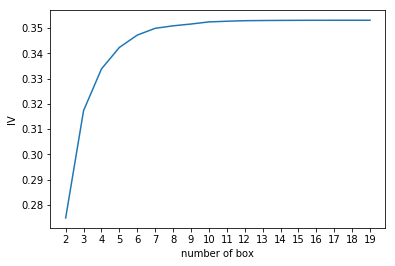

In [23]:
num_bins_ = num_bins.copy() #不希望覆盖原有数据

import matplotlib.pyplot as plt
import scipy

IV = []
axisx = []

while len(num_bins_) > 2:  #大于 设置的最低分箱个数
    pvs = []
    #获取 num_bins_两两之间的卡方检验的置信度（或卡方值）
    for i in range(len(num_bins_)-1):
        x1 = num_bins_[i][2:]
        x2 = num_bins_[i+1][2: ]
        # 0 返回 chi2 值，1 返回 p 值。
        pv = scipy.stats.chi2_contingency([x1,x2])[1]#p值
        # chi2 = scipy.stats.chi2_contingency([x1,x2])[0]#计算卡方值
        pvs.append(pv)

    # 通过 p 值进行处理。合并 p 值最大的两组
    i = pvs.index(max(pvs))
    num_bins_[i:i+2] = [(
            num_bins_[i][0],
            num_bins_[i+1][1],
            num_bins_[i][2]+num_bins_[i+1][2],
            num_bins_[i][3]+num_bins_[i+1][3])]

    bins_df = get_woe(num_bins_)
    axisx.append(len(num_bins_))
    IV.append(get_iv(bins_df))

plt.figure()
plt.plot(axisx,IV)
plt.xticks(axisx)
plt.xlabel("number of box")
plt.ylabel("IV")
plt.show()
#选择转折点处，也就是下坠最快的折线点，所以这里对于age来说选择箱数为6

In [24]:
def get_bin(num_bins_,n):
    while len(num_bins_) > n:
        pvs = []
        for i in range(len(num_bins_)-1):
            x1 = num_bins_[i][2:]
            x2 = num_bins_[i+1][2:]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            # chi2 = scipy.stats.chi2_contingency([x1,x2])[0]
            pvs.append(pv)

        i = pvs.index(max(pvs))
        num_bins_[i:i+2] = [(
                num_bins_[i][0],
                num_bins_[i+1][1],
                num_bins_[i][2]+num_bins_[i+1][2],
                num_bins_[i][3]+num_bins_[i+1][3])]
    return num_bins_

afterbins = get_bin(num_bins,6)

afterbins
[(21.0, 45.0, 32326, 46990),
 (45.0, 46.99786404880899, 2419, 6019),
 (46.99786404880899, 58.668699156029426, 28282, 30220),
 (58.668699156029426, 64.0, 13551, 7753),
 (64.0, 74.0, 13376, 4766),
 (74.0, 107.0, 7737, 1569)]

bins_df = get_woe(num_bins)
bins_df


,min,max,count_0,count_1,total,percentage,bad_rate,good%,bad%,woe
0,21.0,36.0,14797,24889,39686,0.203510,0.627148,0.151467,0.255752,-0.523837
1,36.0,54.0,39070,51373,90443,0.463791,0.568015,0.399934,0.527893,-0.277594
2,54.0,61.0,15743,12225,27968,0.143420,0.437107,0.161151,0.125620,0.249077
3,61.0,64.0,6968,3222,10190,0.052254,0.316192,0.071327,0.033108,0.767490
4,64.0,74.0,13376,4220,17596,0.090232,0.239827,0.136922,0.043363,1.149791
5,74.0,107.0,7737,1388,9125,0.046793,0.152110,0.079199,0.014263,1.714314


In [25]:
def graphforbestbin(DF, X, Y, n=5,q=20,graph=True):
    '''
    自动最优分箱函数，基于卡方检验的分箱

    参数：
    DF: 需要输入的数据
    X: 需要分箱的列名
    Y: 分箱数据对应的标签 Y 列名
    n: 保留分箱个数
    q: 初始分箱的个数
    graph: 是否要画出IV图像

    区间为前开后闭 (]

    '''

    DF = DF[[X,Y]].copy()

    DF["qcut"],bins = pd.qcut(DF[X], retbins=True, q=q,duplicates="drop")
    coount_y0 = DF.loc[DF[Y]==0].groupby(by="qcut").count()[Y]
    coount_y1 = DF.loc[DF[Y]==1].groupby(by="qcut").count()[Y]
    num_bins = [*zip(bins,bins[1:],coount_y0,coount_y1)]

    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(
                num_bins[0][0],
                num_bins[1][1],
                num_bins[0][2]+num_bins[1][2],
                num_bins[0][3]+num_bins[1][3])]
            continue

        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1] = [(
                    num_bins[i-1][0],
                    num_bins[i][1],
                    num_bins[i-1][2]+num_bins[i][2],
                    num_bins[i-1][3]+num_bins[i][3])]
                break
        else:
            break

    def get_woe(num_bins):
        columns = ["min","max","count_0","count_1"]
        df = pd.DataFrame(num_bins,columns=columns)
        df["total"] = df.count_0 + df.count_1
        df["percentage"] = df.total / df.total.sum()
        df["bad_rate"] = df.count_1 / df.total
        df["good%"] = df.count_0/df.count_0.sum()
        df["bad%"] = df.count_1/df.count_1.sum()
        df["woe"] = np.log(df["good%"] / df["bad%"])
        return df

    def get_iv(df):
        rate = df["good%"] - df["bad%"]
        iv = np.sum(rate * df.woe)
        return iv

    IV = []
    axisx = []
    while len(num_bins) > n:
        pvs = []
        for i in range(len(num_bins)-1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            pvs.append(pv)

        i = pvs.index(max(pvs))
        num_bins[i:i+2] = [(
            num_bins[i][0],
            num_bins[i+1][1],
            num_bins[i][2]+num_bins[i+1][2],
            num_bins[i][3]+num_bins[i+1][3])]

        bins_df = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_df))

    if graph:
        plt.figure()
        plt.plot(axisx,IV)
        plt.xticks(axisx)
        plt.xlabel("number of box")
        plt.ylabel("IV")
        plt.show()
    return bins_df

RevolvingUtilizationOfUnsecuredLines


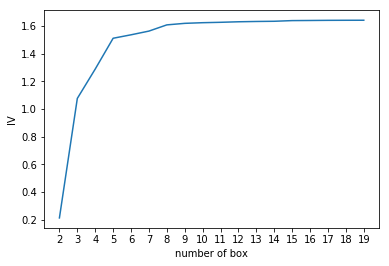

age


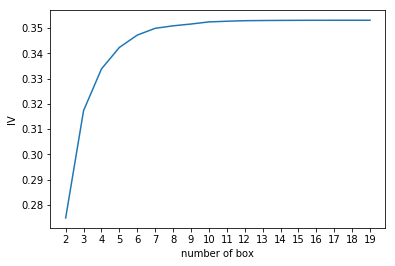

NumberOfTime30-59DaysPastDueNotWorse


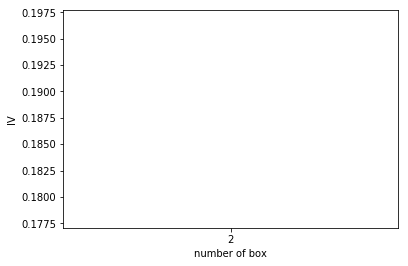

DebtRatio


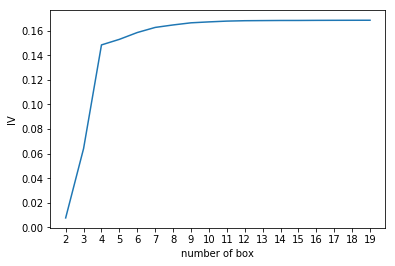

MonthlyIncome


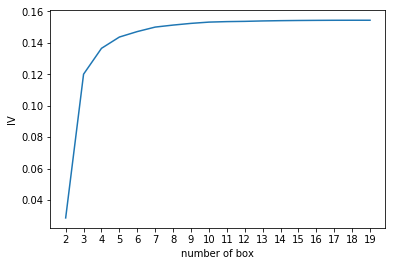

NumberOfOpenCreditLinesAndLoans


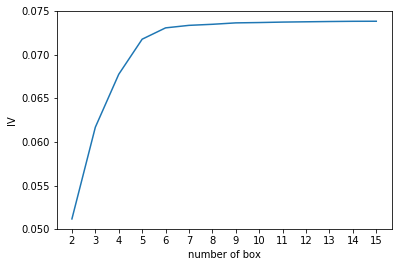

NumberOfTimes90DaysLate


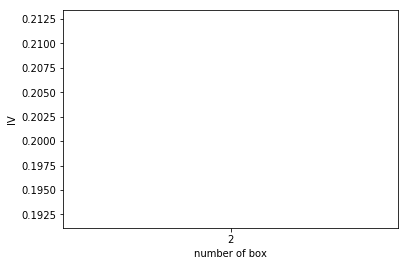

NumberRealEstateLoansOrLines


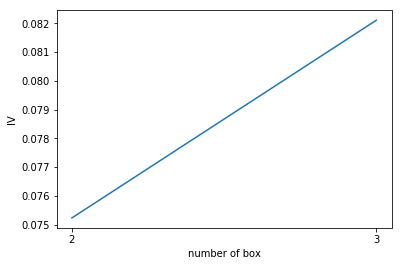

NumberOfTime60-89DaysPastDueNotWorse


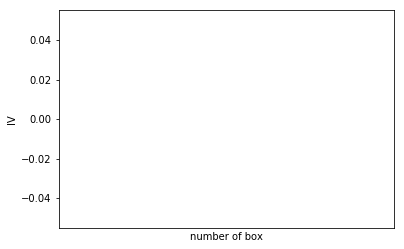

UnboundLocalError: local variable 'bins_df' referenced before assignment

In [26]:
model_data.columns

for i in model_data.columns[1:-1]:
    print(i)
    graphforbestbin(model_data,i,"SeriousDlqin2yrs",n=2,q=20)

In [28]:
auto_col_bins = {"RevolvingUtilizationOfUnsecuredLines":6,
                "age":5,
                "DebtRatio":4,
                "MonthlyIncome":3,
                "NumberOfOpenCreditLinesAndLoans":5}

#不能使用自动分箱的变量
hand_bins = {"NumberOfTime30-59DaysPastDueNotWorse":[0,1,2,13]
            ,"NumberOfTimes90DaysLate":[0,1,2,17]
            ,"NumberRealEstateLoansOrLines":[0,1,2,4,54]
            ,"NumberOfTime60-89DaysPastDueNotWorse":[0,1,2,8]
            ,"NumberOfDependents":[0,1,2,3]}
hand_bins = {k:[-np.inf,*v[:-1],np.inf] for k,v in hand_bins.items()}

In [29]:
bins_of_col = {}

#生成自动分箱的分箱区间和分箱后的IV值

for col in auto_col_bins:
    bins_df = graphforbestbin(model_data,col
                             ,"SeriousDlqin2yrs"
                             ,n=auto_col_bins[col]
                             #使用字典的性质来取出每个特征所对应的箱的数量
                             ,q=20
                             ,graph=False)
    bins_list = sorted(set(bins_df["min"]).union(bins_df["max"]))
    #保证区间覆盖使用 np.inf 替换最大值 -np.inf 替换最小值
    bins_list[0],bins_list[-1] = -np.inf,np.inf
    bins_of_col[col] = bins_list

#合并手动分箱数据    
bins_of_col.update(hand_bins)

bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.0990299395,
  0.2978006212898538,
  0.46503500020821453,
  0.982374313259656,
  0.9999998999999999,
  inf],
 'age': [-inf, 36.0, 54.0, 61.0, 74.0, inf],
 'DebtRatio': [-inf,
  0.01745222145,
  0.4017594401319138,
  1.4692109515489487,
  inf],
 'MonthlyIncome': [-inf, 0.09634116830810353, 5595.922526737865, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 17.0, inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

In [30]:
data = model_data.copy()

#函数pd.cut，可以根据已知的分箱间隔把数据分箱
#参数为 pd.cut(数据，以列表表示的分箱间隔)
data = data[["age","SeriousDlqin2yrs"]].copy()

data["cut"] = pd.cut(data["age"],[-np.inf, 48.49986200790144, 58.757170160044694, 64.0, 74.0, np.inf])

data.head()
data.groupby("cut")["SeriousDlqin2yrs"].value_counts()
#使用unstack()来将树状结构变成表状结构
data.groupby("cut")["SeriousDlqin2yrs"].value_counts().unstack()

bins_df = data.groupby("cut")["SeriousDlqin2yrs"].value_counts().unstack()

bins_df["woe"] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))

bins_df    
def get_woe(df,col,y,bins):
    df = df[[col,y]].copy()
    df["cut"] = pd.cut(df[col],bins)
    bins_df = df.groupby("cut")[y].value_counts().unstack()
    woe = bins_df["woe"] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
    return woe

#将所有特征的WOE存储到字典当中
woeall = {}
for col in bins_of_col:
    woeall[col] = get_woe(model_data,col,"SeriousDlqin2yrs",bins_of_col[col])

woeall

{'RevolvingUtilizationOfUnsecuredLines': cut
 (-inf, 0.099]     2.200749
 (0.099, 0.298]    0.668818
 (0.298, 0.465]   -0.127577
 (0.465, 0.982]   -1.073587
 (0.982, 1.0]     -0.481903
 (1.0, inf]       -2.030229
 dtype: float64, 'age': cut
 (-inf, 36.0]   -0.523837
 (36.0, 54.0]   -0.277594
 (54.0, 61.0]    0.249077
 (61.0, 74.0]    1.001811
 (74.0, inf]     1.714314
 dtype: float64, 'DebtRatio': cut
 (-inf, 0.0175]     1.514027
 (0.0175, 0.402]    0.036715
 (0.402, 1.469]    -0.389596
 (1.469, inf]       0.175920
 dtype: float64, 'MonthlyIncome': cut
 (-inf, 0.0963]        1.261365
 (0.0963, 5595.923]   -0.228114
 (5595.923, inf]       0.231104
 dtype: float64, 'NumberOfOpenCreditLinesAndLoans': cut
 (-inf, 1.0]   -0.850502
 (1.0, 3.0]    -0.327723
 (3.0, 5.0]    -0.051543
 (5.0, 17.0]    0.122842
 (17.0, inf]    0.463135
 dtype: float64, 'NumberOfTime30-59DaysPastDueNotWorse': cut
 (-inf, 0.0]    0.350109
 (0.0, 1.0]    -0.868614
 (1.0, 2.0]    -1.374281
 (2.0, inf]    -1.537690
 dt

In [31]:
#不希望覆盖掉原本的数据，创建一个新的DataFrame，索引和原始数据model_data一模一样
model_woe = pd.DataFrame(index=model_data.index)

#将原数据分箱后，按箱的结果把WOE结构用map函数映射到数据中
model_woe["age"] = pd.cut(model_data["age"],bins_of_col["age"]).map(woeall["age"])

#对所有特征操作可以写成：
for col in bins_of_col:
    model_woe[col] = pd.cut(model_data[col],bins_of_col[col]).map(woeall[col])

#将标签补充到数据中
model_woe["SeriousDlqin2yrs"] = model_data["SeriousDlqin2yrs"]

#这就是我们的建模数据了
model_woe.head()

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,-0.277594,2.200749,0.036715,-0.228114,-0.051543,0.350109,0.235982,-0.394523,0.124270,0.624564,0
1,1.001811,0.668818,0.036715,-0.228114,-0.051543,0.350109,0.235982,-0.394523,0.124270,0.624564,0
2,-0.277594,-2.030229,-0.389596,-0.228114,-0.051543,-0.868614,-1.756182,-0.394523,-1.765213,-0.476859,1
3,1.001811,2.200749,-0.389596,-0.228114,0.122842,0.350109,0.235982,0.616699,0.124270,0.624564,0
4,-0.277594,-1.073587,-0.389596,0.231104,0.122842,0.350109,0.235982,0.616699,0.124270,-0.579384,1


In [32]:
vali_woe = pd.DataFrame(index=vali_data.index)

for col in bins_of_col:
    vali_woe[col] = pd.cut(vali_data[col],bins_of_col[col]).map(woeall[col])

vali_woe["SeriousDlqin2yrs"] = vali_data["SeriousDlqin2yrs"]

In [33]:
vali_X = vali_woe.iloc[:,:-1]
vali_y = vali_woe.iloc[:,-1]
X = model_woe.iloc[:,:-1]
y = model_woe.iloc[:,-1]

from sklearn.linear_model import LogisticRegression as LR

lr = LR().fit(X,y)
lr.score(vali_X,vali_y)

0.7745764334258639

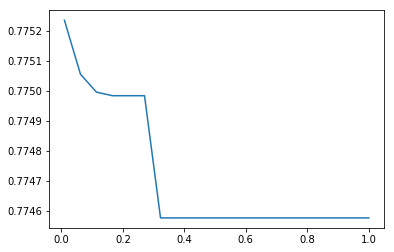

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

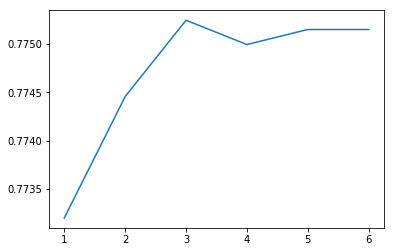

In [34]:
c_1 = np.linspace(0.01,1,20)
c_2 = np.linspace(0.01,0.2,20)

score = []
for i in c_1: 
    lr = LR(solver='liblinear',C=i).fit(X,y)
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot(c_1,score)
plt.show()

lr.n_iter_

score = []
for i in [1,2,3,4,5,6]: 
    lr = LR(solver='liblinear',C=0.025,max_iter=i).fit(X,y)
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot([1,2,3,4,5,6],score)
plt.show()

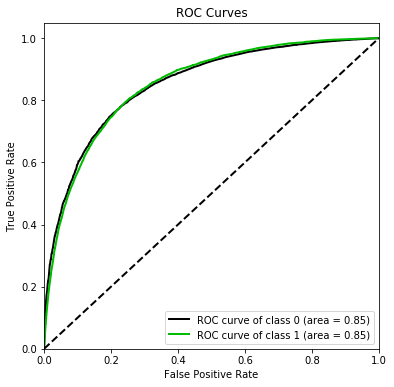

In [35]:
import scikitplot as skplt

vali_proba_df = pd.DataFrame(lr.predict_proba(vali_X))

skplt.metrics.plot_roc(vali_y, vali_proba_df,
                        plot_micro=False,figsize=(6,6),
                        plot_macro=False)

In [41]:
x = np.array([[1,-np.log(1/20)],[1,-np.log(1/40)]])
b = np.array([600,620])
A,B = np.linalg.solve(x,b)

In [42]:
(A,B)

(513.5614381022527, 28.853900817779266)

In [43]:
base_score = A - B*lr.intercept_                 #lr.intercept_：截距
base_score

array([513.69958055])

In [44]:
score_age = woeall["age"] * (-B*lr.coef_[0][1])  #lr.coef_：每一个特征建模之后得出的系数
score_age                                        #"age"特征中每个箱对应的分数

age
(-inf, 36.0]   -11.323986
(36.0, 54.0]    -6.000845
(54.0, 61.0]     5.384392
(61.0, 74.0]    21.656518
(74.0, inf]     37.058979
dtype: float64

In [45]:
file = "./ScoreData.csv"

#open是用来打开文件的python命令，第一个参数是文件的路径+文件名
#如果你的文件是放在根目录下，则你只需要文件名就好
#第二个参数是打开文件后的用途，"w"表示用于写入，通常使用的是"r"，表示打开来阅读
#首先写入基准分数
#之后使用循环，每次生成一组score_age类似的分档和分数，不断写入文件之中

with open(file,"w") as fdata:
    fdata.write("base_score,{}\n".format(base_score))
for i,col in enumerate(X.columns):
    score = woeall[col] * (-B*lr.coef_[0][i])
    score.name = "Score"
    score.index.name = col
    score.to_csv(file,header=True,mode="a")